In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob,os
import netCDF4
from datetime import datetime, timedelta
from matplotlib.dates import date2num
import pandas as pd
import h5py
from scipy.ndimage import gaussian_filter
from pyproj import Proj
from scipy.spatial import cKDTree
import seaborn as sns

In [5]:
path = '/data/keeling/a/kheimes2/more_space/Data/IMPACTS/'
days = ['20200125','20230129']
fl_choice='P3'

In [6]:
def fldef_synch(day):   
    if day=='20200125':
        lowtype='MB'
        region='NE'
        er2_fl=[['2020-01-25 19:20:00', '2020-01-25 19:32:00', '1'],
                ['2020-01-25 20:00:30', '2020-01-25 20:17:00', '2'],
                ['2020-01-25 20:32:00', '2020-01-25 20:50:00', '3'],
                ['2020-01-25 21:04:30', '2020-01-25 21:22:15', '4'],
                ['2020-01-25 21:36:00', '2020-01-25 21:54:00', '5'],
                ['2020-01-25 22:13:15', '2020-01-25 22:22:15', '6'], # Not great coordination in time
                ['2020-01-25 22:21:00', '2020-01-25 22:31:00', '7'],
                ['2020-01-25 22:43:30', '2020-01-25 22:58:00', '8']] # Not great coordination in time
        p3_fl= [['2020-01-25 19:21:00', '2020-01-25 19:33:00', '1'], # P3 above of cloud echo?
                ['2020-01-25 20:02:00', '2020-01-25 20:19:30', '2'], # No cloud echo?
                ['2020-01-25 20:34:00', '2020-01-25 20:49:30', '3'], # P3 in then OUT of cloud?
                ['2020-01-25 21:02:00', '2020-01-25 21:21:00', '4'], # P3 OUT then in cloud?
                ['2020-01-25 21:34:00', '2020-01-25 21:51:00', '5'],
                ['2020-01-25 22:05:15', '2020-01-25 22:13:30', '6'], # P3 at cloud top?
                ['2020-01-25 22:17:45', '2020-01-25 22:27:00', '7'],
                ['2020-01-25 22:45:00', '2020-01-25 23:03:00', '8']] # P3 OUT then in cloud?
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200125.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        
    if day=='20230129':
        lowtype='AF'
        region='NE'
        er2_fl=[['2023-01-29 14:53:45', '2023-01-29 15:15:00', '1'],
                ['2023-01-29 15:27:45', '2023-01-29 15:43:06', '2'],
                ['2023-01-29 15:55:30', '2023-01-29 16:13:00', '3'],
                ['2023-01-29 16:22:00', '2023-01-29 16:40:30', '4']]
        p3_fl= [['2023-01-29 14:46:15', '2023-01-29 15:18:15', '1'],
                ['2023-01-29 15:23:00', '2023-01-29 15:46:00', '2'],
                ['2023-01-29 15:51:00', '2023-01-29 16:13:30', '3'],
                ['2023-01-29 16:18:30', '2023-01-29 16:46:15', '4']]
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230129.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'

    return(er2_fl,p3_fl, lowtype, wfile, hifile_ka, hifile_ku, region)

In [13]:
# Compute relevant microphysical quantities
def mp_calcs(ND,D,dD,ar,a,b, mD, source):
    """
    INPUT UNITS:
    ND MUST BE IN CM^-4
    D IN CM
    dD IN CM
    mD in kg
    
    INPUT SHAPES:
    ND: n_samples,n_bins
    D: n_bins
    dD: n_bins 
    
    OUTPUT UNITS:
    Dm: m
    Dm_liquid: m
    IWC: g/m^3
    Nt: #/m^3 
    rho: g/cm^3
    V: cm^3/cm^3
    Nw: m^-4?
    """

    if source=='obs':
        n_samples = ND.shape[0]
        n_bins = ND.shape[1]
        #tile D and dD to match ND
        D = np.reshape(D,[1,n_bins])
        D = np.tile(D,(n_samples,1))
        dD = np.reshape(dD,[1,n_bins])
        dD = np.tile(dD,(n_samples,1))

        mass_particle=a*D**b

    if source=='chosen':
        mass_particle=mD*1000 #[g]
    
    #get Nt
    M0 = np.nansum(ND*dD,axis=1)
    #get IWC 
    M3 = np.nansum((mass_particle)*(ND*dD),axis=1)
    #get top of Dm 
    M4 = np.nansum((mass_particle)*(D*ND*dD),axis=1)
    
    #get Dm 
    Dm = M4/M3 
    
    #get_total_spherical_volume 
    # V = np.nansum((np.pi/6.)*D**3*(ND*dD),axis=1)
    V = np.nansum((np.pi/6.)*(ND*dD)*ar*D**3,axis=1)
    
    #get effective density 
    rhoe = M3/V

    #get Nw
    D_melt = ((6. * mass_particle) / (np.pi * 0.997))**(1./3.)
    Nw = (4.**4 / 6) * np.nansum(D_melt**3 * ND * dD, axis=1)**5 / np.nansum(D_melt**4 * ND * dD, axis=1)**4
    Nw=Nw*1e8 # cm^-4 to m^-4

    # Get Dm_liquid
    # M3_liq= np.nansum(D_melt**3.*ND*dD,axis=1)
    # M4_liq = np.nansum(D_melt**4.*ND*dD,axis=1)
    M3_liq= np.nansum((mass_particle)*ND*dD,axis=1)
    M4_liq = np.nansum((mass_particle)*D_melt*ND*dD,axis=1)
    Dm_liquid = M4_liq/M3_liq

    Nt = M0*1e6 # number/cm^3 to number/m^3
    IWC = M3*1e6 # convert from g/cm^3 to g/m^3
    Dm = Dm/100 #convert from cm to m
    V = V #cm^3/cm^3 
    # rhoe = rhoe*1e6 #g/m^3
    Dm_liquid = Dm_liquid/100
    
    return Dm,Dm_liquid,IWC,Nt,Nw,rhoe,V

In [14]:
# m-D coefficients to calculate microphysics quantities

# Heymsfield 2004, D must be in cm   (its in cgs)
a = 0.0061
b = 2.05

#Leinonen and S. 2015
a_L15 = np.array([0.015, 0.0354, 0.0545, 0.126, 0.369, 1.7])
b_L15 = np.array([2.08, 2.06, 2.05, 2.03, 2.11, 2.3])
a_L15 = (10.**(3-2*b_L15)) * a_L15

<xarray.Dataset> Size: 2MB
Dimensions:              (Time: 3311, binmid: 38, binend: 39, bin_width: 38)
Coordinates:
  * Time                 (Time) datetime64[ns] 26kB 2023-01-29T13:29:04 ... 2...
  * binmid               (binmid) float32 152B 112.5 137.5 ... 2.25e+04 2.75e+04
  * binend               (binend) float32 156B 100.0 125.0 ... 2.5e+04 3e+04
  * bin_width            (bin_width) float32 152B 25.0 25.0 50.0 ... 5e+03 5e+03
Data variables:
    Average_CONC         (Time, binmid) float64 1MB ...
    Average_ASPECTRATIO  (Time, binmid) float32 503kB ...
    nav_alt              (Time) float64 26kB ...
    nav_lat              (Time) float64 26kB ...
    nav_lon              (Time) float64 26kB ...
    nav_temp             (Time) float64 26kB ...
Attributes:
    bin_endpoints:  [  100.   125.   150.   200.   250.   300.   350.   400. ...
    bin_midpoints:  [  112.5   137.5   175.    225.    275.    325.    375.  ...
<xarray.Dataset> Size: 2MB
Dimensions:              (Time: 3311

/data/keeling/a/kheimes2/miniconda3/envs/xarray-climate/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_3640881/803787298.py:47: RuntimeWarning: invalid value encountered in divide
  Dm = M4/M3
/tmp/ipykernel_3640881/803787298.py:54: RuntimeWarning: invalid value encountered in divide
  rhoe = M3/V
/tmp/ipykernel_3640881/803787298.py:58: RuntimeWarning: invalid value encountered in divide
  Nw = (4.**4 / 6) * np.nansum(D_melt**3 * ND * dD, axis=1)**5 / np.nansum(D_melt**4 * ND * dD, axis=1)**4
/tmp/ipykernel_3640881/803787298.py:66: RuntimeWarning: invalid value encountered in divide
  Dm_liquid = M4_liq/M3_liq
/data/keeling/a/kheimes2/miniconda3/envs/xarray-climate/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_3640881/803787298.py:47: RuntimeWar

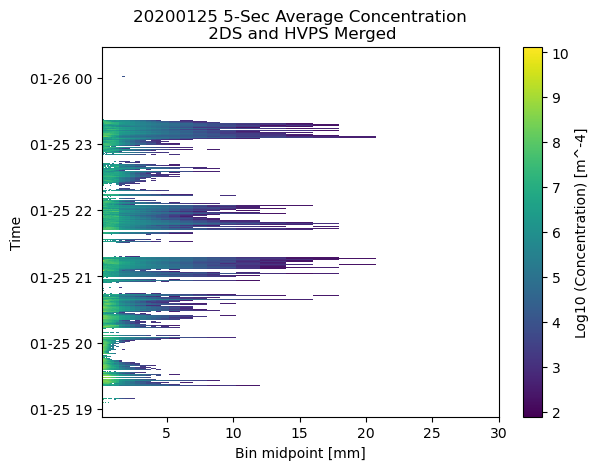

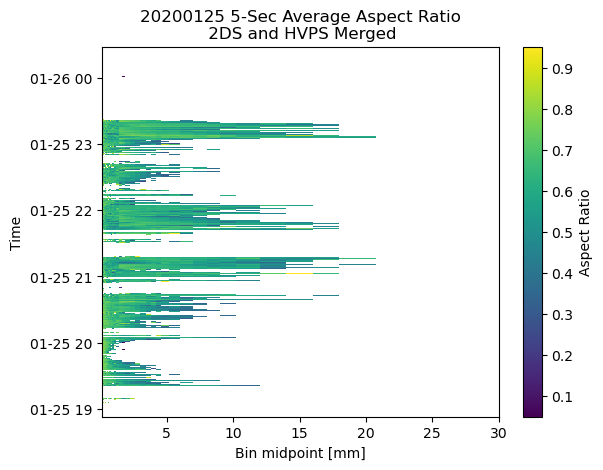

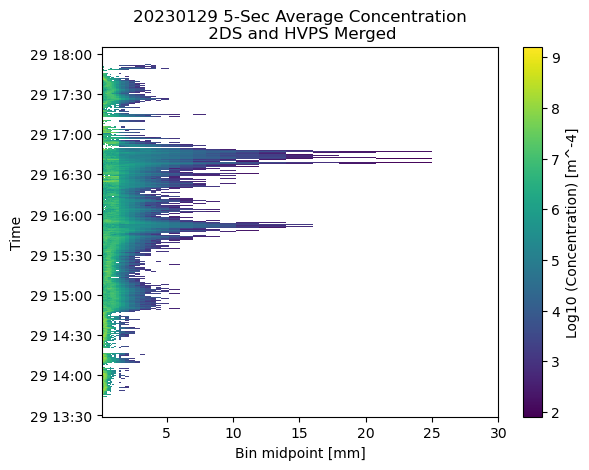

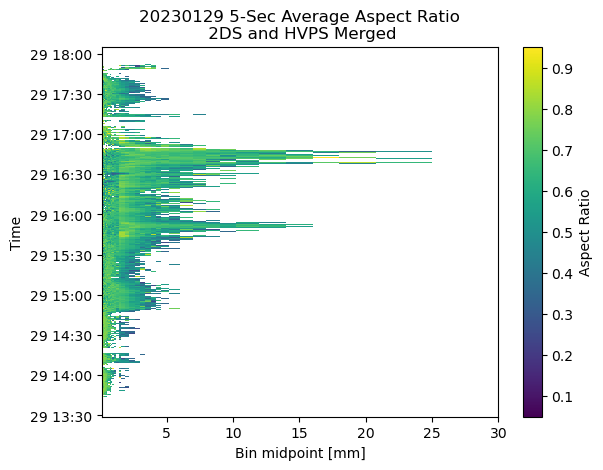

In [16]:
param_df_ls = []
conc_df_ls = []

for n in range(len(days)):
    PSD_ds = xr.open_dataset('merged_2DS_HVPS_5sec_avg_'+days[n]+'.nc')
    print(PSD)

    plt.figure()
    plt.pcolormesh(PSD_ds.Average_CONC.binmid/10**3, PSD_ds.Time, np.log10(PSD_ds.Average_CONC), cmap='viridis')
    plt.colorbar(label='Log10 (Concentration) [m^-4]')
    plt.xlabel('Bin midpoint [mm]')
    plt.ylabel('Time')
    plt.title(days[n]+' 5-Sec Average Concentration\n 2DS and HVPS Merged')

    plt.figure()
    plt.pcolormesh(PSD_ds.Average_ASPECTRATIO.binmid/10**3, PSD_ds.Time, PSD_ds.Average_ASPECTRATIO.values, cmap='viridis')
    plt.colorbar(label='Aspect Ratio')
    plt.xlabel('Bin midpoint [mm]')
    plt.ylabel('Time')
    plt.title(days[n]+' 5-Sec Average Aspect Ratio\n 2DS and HVPS Merged')

    Dm_HY,Dm_liquid_HY,IWC_HY,Nt,Nw_HY,Rho_HY,V = mp_calcs(PSD_ds.Average_CONC.values*1e-8,
                                                       PSD_ds.binmid.values*1e-4,
                                                       PSD_ds.bin_width.values*1e-4,
                                                       PSD_ds.Average_ASPECTRATIO.values,
                                                       a,b,0, 'obs')
    # #Leinonen and S. 2015 a,b values
    # Dm_L15 = np.zeros([PSD_ds.Time.shape[0],len(a_L15)])
    # Dm_liquid_L15 = np.zeros([PSD_ds.Time.shape[0],len(a_L15)])
    # IWC_L15 = np.zeros([PSD_ds.Time.shape[0],len(a_L15)])
    # Nw_L15 = np.zeros([PSD_ds.Time.shape[0],len(a_L15)])
    # Rho_L15 = np.zeros([PSD_ds.Time.shape[0],len(a_L15)])
    # for i in np.arange(len(a_L15)):
    #     Dm_L15[:,i],Dm_liquid_L15[:,i],IWC_L15[:,i],_,Nw_L15[:,i],Rho_L15[:,i],_ = mp_calcs(PSD_ds.Average_CONC.values*1e-8,
    #                                                                                           PSD_ds.binmid.values*1e-4,
    #                                                                                           PSD_ds.bin_width.values*1e-4,
    #                                                                                           a_L15[i],b_L15[i], 0, 'obs')

    # calc_mp_df=pd.DataFrame([Dm_HY, Dm_liquid_HY, np.log10(Nw_HY)-3, IWC_HY_corr, PSD_ds.nav_temp.values, PSD_ds.nav_lat.values, PSD_ds.nav_lon.values, 
    #                          PSD_ds.nav_alt.values], columns=PSD_ds.Time.values, 
    #                          index=['Dm Solid','Dm Liquid','Nw','IWC','Temp','Lat','Lon','Alt']).T
    # calc_mp_df_ls.append(calc_mp_df)

    # Making a Dataframe of calculated microphysical properties
    param_df = pd.DataFrame()
    param_df['Dm'] = Dm_HY
    param_df['Dm_liq'] = Dm_liquid_HY
    param_df['IWC'] = IWC_HY
    param_df['Nw'] = Nw_HY
    param_df['Rho'] = Rho_HY
    param_df['Time'] = PSD_ds.Time
    # param_df['Stability'] = np.ones(Dm_HY.shape)
    param_df = param_df.set_index('Time')
    # Drop anywhere with nans
    param_df_nonan = param_df.dropna(how='any')

    param_df_ls.append(param_df_nonan)

    # Dataframe of just average concentrations
    conc_df = pd.DataFrame(PSD_ds.Average_CONC.values, columns = PSD_ds.binmid.values)
    conc_df['Time'] = PSD_ds.Time
    conc_df = conc_df.set_index('Time')
    # Removing data with nan
    conc_df_nonan = conc_df.dropna(how='any')

    conc_df_ls.append(conc_df_nonan)


In [17]:
param_tog = pd.concat(param_df_ls)
param_tog

,Dm,Dm_liq,IWC,Nw,Rho
Time,,,,,
2020-01-25 19:05:21,0.000415,0.000254,0.018956,3.737674e+08,0.311114
2020-01-25 19:05:26,0.000764,0.000389,0.012387,4.424304e+07,0.168944
2020-01-25 19:05:31,0.000171,0.000140,0.000990,2.079755e+08,0.687958
2020-01-25 19:05:36,0.000255,0.000177,0.034729,2.904356e+09,0.518487
2020-01-25 19:05:41,0.000167,0.000137,0.024283,5.653909e+09,0.704767
...,...,...,...,...,...
2023-01-29 17:51:54,0.003069,0.001005,0.001571,1.260445e+05,0.085212
2023-01-29 17:51:59,0.003467,0.001090,0.001796,1.039401e+05,0.058021
2023-01-29 17:52:04,0.002496,0.000857,0.001172,1.774947e+05,0.067214


In [ ]:
conc_tog = pd.concat(conc_df_ls)
conc_tog

,112.5,137.5,175.0,225.0,275.0,325.0,375.0,437.5,512.5,587.5,...,7500.0,8500.0,9500.0,11000.0,13000.0,15000.0,17000.0,19000.0,22500.0,27500.0
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-25 19:05:21,5.623446e+07,4.217584e+07,0.000000e+00,0.000000e+00,1.405861e+07,7.029307e+06,7.029307e+06,4.686205e+06,0.000000e+00,4.686205e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:26,2.669018e+06,2.669018e+06,0.000000e+00,0.000000e+00,1.204340e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.605786e+06,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:31,6.260543e+06,6.001095e+06,7.866285e+06,1.200219e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:36,5.473627e+08,2.219038e+08,7.766632e+07,4.438076e+07,7.396793e+06,0.000000e+00,3.698396e+06,0.000000e+00,0.000000e+00,4.931195e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:41,5.217002e+08,1.333670e+08,9.610266e+07,2.941918e+07,7.845115e+06,1.961279e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-29 17:51:49,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-29 17:51:54,1.923611e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-29 17:51:59,1.778529e+06,1.778529e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
param_conc_df = pd.merge(param_tog, conc_tog, left_index=True, right_index=True, how='inner')

# Performing K-means Clustering
Adapted from: Ladino et al. (2025)
https://github.com/aladinor/Ladino_et_al_2025_DNN_PSD_retrieval.git

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [21]:
def get_kmeans_score(df, center):
    '''
    returns the elbow inertial index, the Davies Bouldin and Silhouette score
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        elbow inertial index, the Davies Bouldin and Silhouette score
    '''
    kmeans = KMeans(n_clusters=center, random_state=10)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow

In [42]:
# Standardize the features that will be used to group PSDs
scaler = StandardScaler()
param_conc_df[['Dm_T', 'Dm_liq_T', 'IWC_T', 'Nw_T', 'Rho_T']] = scaler.fit_transform(param_conc_df[['Dm', 'Dm_liq', 'IWC', 'Nw', 'Rho']])

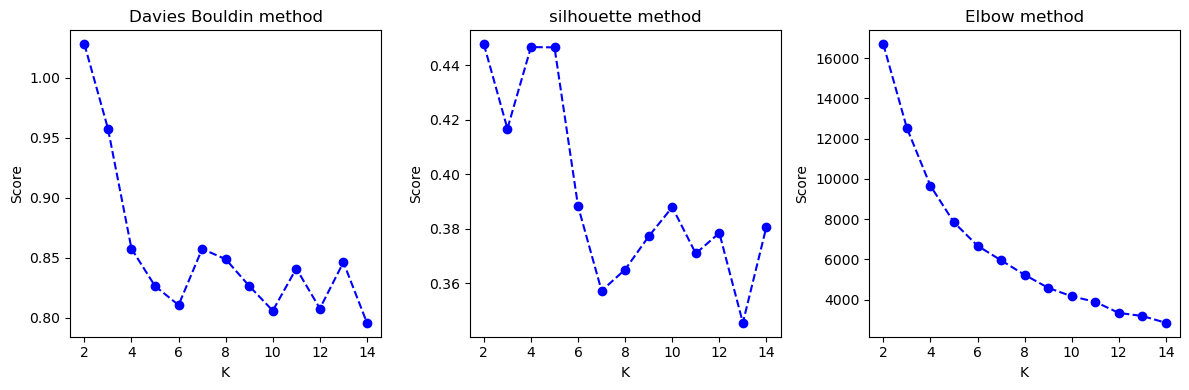

In [43]:
# Determine the number of clusters using the Davies Bouldin test, Silhouette Score, and Elbow Method
dav = []
sil = []
elbow = []

for k in range(2,15):
    _dav, _sil, _el = get_kmeans_score(param_conc_df[['Dm_T', 'Dm_liq_T', 'IWC_T', 'Nw_T', 'Rho_T']], k)
    dav.append(_dav)
    sil.append(_sil)
    elbow.append(_el)

centers = range(2,15)
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
ax1.set_xlabel('K');
ax1.set_ylabel('Score');
ax1.set_title('silhouette method');

ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax2.set_xlabel('K');
ax2.set_ylabel('Score');
ax2.set_title('Elbow method');
fig.tight_layout()

In [48]:
# Choose the number of clusters with a low Davie Bouldin Score, High Silhouette Score, and Elbow in the Elbow method
nclusters = 5

In [49]:
# Perform the grouping using default settings
kmeans = KMeans(n_clusters= nclusters, random_state=10)
kmeans.fit(param_conc_df[['Dm_T', 'Dm_liq_T', 'IWC_T', 'Nw_T', 'Rho_T']])

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,10
,copy_x,True
,algorithm,'lloyd'


In [50]:
# Making a dataframe of group number for PSDs
kmean_cat_df = pd.DataFrame(kmeans.labels_, columns = ['Group'])
kmean_cat_df['Time'] = param_conc_df.index
kmean_cat_df = kmean_cat_df.set_index('Time')
kmean_cat_df

,Group
Time,
2020-01-25 19:05:21,1
2020-01-25 19:05:26,0
2020-01-25 19:05:31,1
2020-01-25 19:05:36,1
2020-01-25 19:05:41,1
...,...
2023-01-29 17:51:49,0
2023-01-29 17:51:54,3
2023-01-29 17:51:59,3


In [ ]:
# Adding the group number to the dataframe with PSD parameters
param_conc_df['Kmean_group'] = kmean_cat_df['Group']
param_conc_df

Index([         'Dm',      'Dm_liq',         'IWC',          'Nw',
               'Rho',        'Dm_T',    'Dm_liq_T',       'IWC_T',
              'Nw_T',       'Rho_T', 'Kmean_group',         112.5,
               137.5,         175.0,         225.0,         275.0,
               325.0,         375.0,         437.5,         512.5,
               587.5,         662.5,         750.0,         850.0,
               950.0,        1100.0,        1300.0,        1500.0,
              1700.0,        2000.0,        2400.0,        2800.0,
              3200.0,        3600.0,        4000.0,        4400.0,
              4800.0,        5500.0,        6500.0,        7500.0,
              8500.0,        9500.0,       11000.0,       13000.0,
             15000.0,       17000.0,       19000.0,       22500.0,
             27500.0],
      dtype='object')

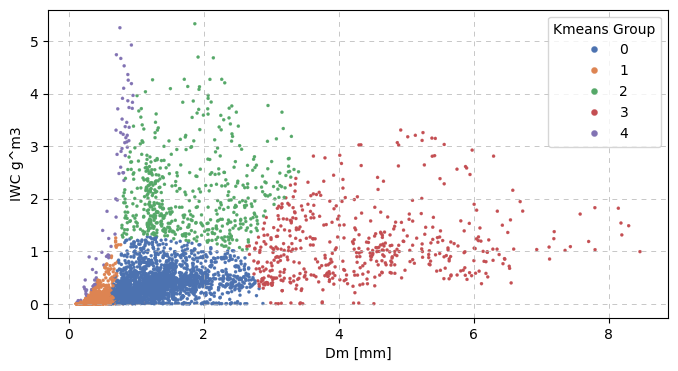

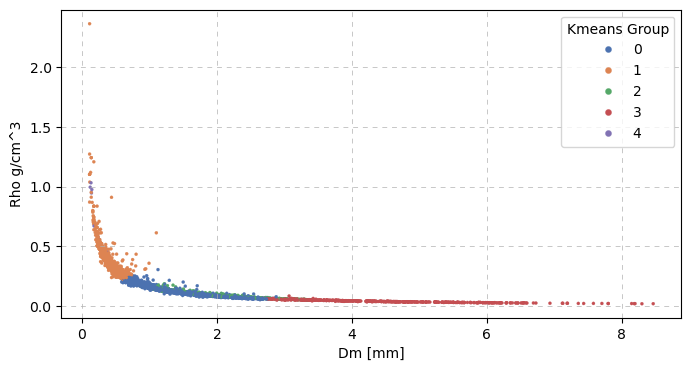

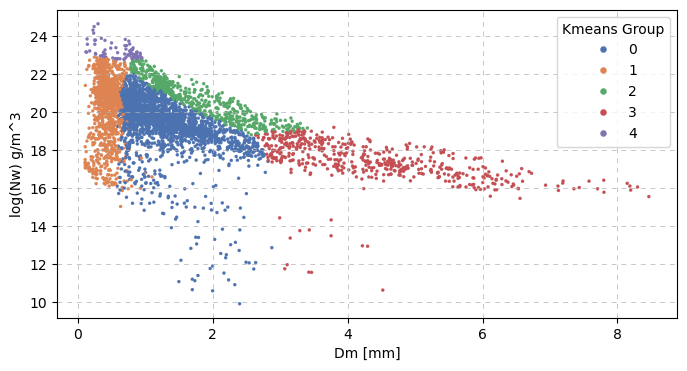

In [53]:
# Plotting results 
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=param_conc_df, x=param_conc_df['Dm']*1000, y=param_conc_df['IWC'], hue=param_conc_df['Kmean_group'], s=5,
                     ax=ax,palette=sns.color_palette('deep', nclusters), 
                     legend=True, edgecolor=None)
ax.set_xlabel('Dm [mm]')
ax.set_ylabel('IWC g^m3')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Kmeans Group',markerscale=2)

# Plotting results 
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=param_conc_df, x=param_conc_df['Dm']*1000, y=param_conc_df['Rho'], hue=param_conc_df['Kmean_group'], s=5,
                     ax=ax,palette=sns.color_palette('deep', nclusters), 
                     legend=True, edgecolor=None)
ax.set_xlabel('Dm [mm]')
ax.set_ylabel('Rho g/cm^3')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Kmeans Group',markerscale=2)

# Plotting results 
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=param_conc_df, x=param_conc_df['Dm']*1000, y=np.log(param_conc_df['Nw']), hue=param_conc_df['Kmean_group'], s=5,
                     ax=ax,palette=sns.color_palette('deep', nclusters), 
                     legend=True, edgecolor=None)
ax.set_xlabel('Dm [mm]')
ax.set_ylabel('log(Nw) g/m^3')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Kmeans Group',markerscale=2)

In [31]:
# epi_grouped = param_tog.iloc[np.where(param_tog['Stability']==1)[0]]
# stable_grouped = param_tog.iloc[np.where(param_tog['Stability']==0)[0]]

In [32]:
# epi_grouped

In [33]:
# bins = np.arange(0, nclusters+1,1)
# bins

In [34]:
# plt.hist(epi_grouped['Kmean_group'], bins=bins)
# plt.hist(stable_grouped['Kmean_group'], bins=bins, alpha=.5)
# plt.xticks(bins)

- Stable Groups: 0,2,6
- EPI Groups: 0, 4, 6
    - Unique: 1, 3, 5,8

In [51]:
# sel_times = param_df_nonan.index.values[np.where(param_df_nonan['Kmean_group']==0)[0]]
# # sel_times

# sel_PSDs = PSD_ds.sel(Time = sel_times)

# plt.figure()
# for n in range(sel_PSDs.Time.shape[0]):
#     plt.step(sel_PSDs.binmid.values*10**-3, (sel_PSDs.Average_CONC.values[n,:])*(sel_PSDs.binmid.values*10**-6))
#     plt.yscale('log')
#     plt.ylabel('Concentration [#/m^-3]')
#     plt.xlabel('Diameter [mm]')
#     plt.title('Normalized PSD for Kmeans Group 0')

# avg_PSD_grp = sel_PSDs.median(dim='Time')

# plt.figure()
# plt.step(sel_PSDs.binmid.values*10**-3,avg_PSD_grp.Average_CONC.values*(sel_PSDs.binmid.values*10**-6))
# plt.yscale('log')
# plt.ylabel('Concentration [#/m^-3]')
# plt.xlabel('Diameter [mm]')
# plt.title('Normalized PSD Averge for all PSDs in Kmeans Group 0')

In [52]:
# sel_times = param_df_nonan.index.values[np.where(param_df_nonan['Kmean_group']==1)[0]]
# # sel_times

# sel_PSDs = PSD_ds.sel(Time = sel_times)

# plt.figure()
# for n in range(sel_PSDs.Time.shape[0]):
#     plt.step(sel_PSDs.binmid.values*10**-3, (sel_PSDs.Average_CONC.values[n,:])*(sel_PSDs.binmid.values*10**-6))
#     plt.yscale('log')
#     plt.ylabel('Concentration [#/m^-3]')
#     plt.xlabel('Diameter [mm]')
#     plt.title('Normalized PSD for Kmeans Group 1')

# avg_PSD_grp = sel_PSDs.median(dim='Time')

# plt.figure()
# plt.step(sel_PSDs.binmid.values*10**-3,avg_PSD_grp.Average_CONC.values*(sel_PSDs.binmid.values*10**-6))
# plt.yscale('log')
# plt.ylabel('Concentration [#/m^-3]')
# plt.xlabel('Diameter [mm]')
# plt.title('Normalized PSD Averge for all PSDs in Kmeans Group 1')

In [55]:
param_conc_df.columns

Index([         'Dm',      'Dm_liq',         'IWC',          'Nw',
               'Rho',        'Dm_T',    'Dm_liq_T',       'IWC_T',
              'Nw_T',       'Rho_T', 'Kmean_group',         112.5,
               137.5,         175.0,         225.0,         275.0,
               325.0,         375.0,         437.5,         512.5,
               587.5,         662.5,         750.0,         850.0,
               950.0,        1100.0,        1300.0,        1500.0,
              1700.0,        2000.0,        2400.0,        2800.0,
              3200.0,        3600.0,        4000.0,        4400.0,
              4800.0,        5500.0,        6500.0,        7500.0,
              8500.0,        9500.0,       11000.0,       13000.0,
             15000.0,       17000.0,       19000.0,       22500.0,
             27500.0],
      dtype='object')

In [56]:
param_conc_df.iloc[:,11::]

,112.5,137.5,175.0,225.0,275.0,325.0,375.0,437.5,512.5,587.5,...,7500.0,8500.0,9500.0,11000.0,13000.0,15000.0,17000.0,19000.0,22500.0,27500.0
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-25 19:05:21,5.623446e+07,4.217584e+07,0.000000e+00,0.000000e+00,1.405861e+07,7.029307e+06,7.029307e+06,4.686205e+06,0.000000e+00,4.686205e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:26,2.669018e+06,2.669018e+06,0.000000e+00,0.000000e+00,1.204340e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.605786e+06,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:31,6.260543e+06,6.001095e+06,7.866285e+06,1.200219e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:36,5.473627e+08,2.219038e+08,7.766632e+07,4.438076e+07,7.396793e+06,0.000000e+00,3.698396e+06,0.000000e+00,0.000000e+00,4.931195e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 19:05:41,5.217002e+08,1.333670e+08,9.610266e+07,2.941918e+07,7.845115e+06,1.961279e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-29 17:51:49,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-29 17:51:54,1.923611e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-29 17:51:59,1.778529e+06,1.778529e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
grouped_data_ls = []
avg_conc_ls = []

for n in range(nclusters):
    sel_times = param_conc_df.index.values[np.where(param_conc_df['Kmean_group']==n)[0]]
    sel_PSDs = PSD_ds.sel(Time = sel_times)
    grouped_data_ls_EPI.append(sel_PSDs)
    avg_conc_ls_EPI.append(grouped_data_ls_EPI[n].Average_CONC.median(dim='Time'))

['2020-01-25T19:05:26.000000000' '2020-01-25T19:08:56.000000000'
 '2020-01-25T19:09:11.000000000' ... '2023-01-29T17:51:49.000000000'
 '2023-01-29T17:52:04.000000000' '2023-01-29T17:52:24.000000000']


TypeError: unhashable type: 'DatetimeIndex'

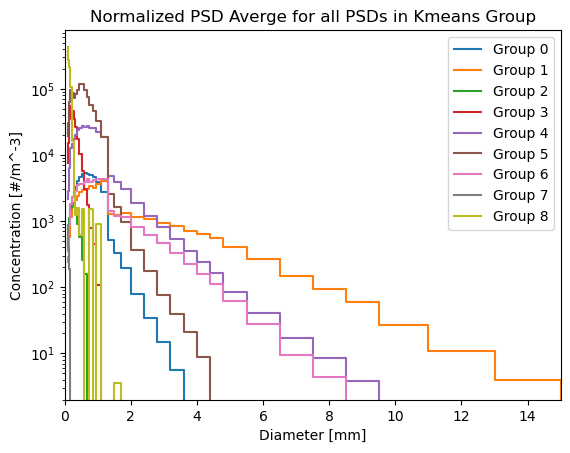

In [54]:
labels = ['Group 0', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8']
for n in range(nclusters):
    plt.step(PSD_ds.binmid.values*10**-3,avg_conc_ls_EPI[n].values*(PSD_ds.binmid.values*10**-6), label=labels[n])
    plt.yscale('log')
    plt.xlim(0,15)
    plt.legend()
    plt.ylabel('Concentration [#/m^-3]')
    plt.xlabel('Diameter [mm]')
    plt.title('Normalized PSD Averge for all PSDs in Kmeans Group')

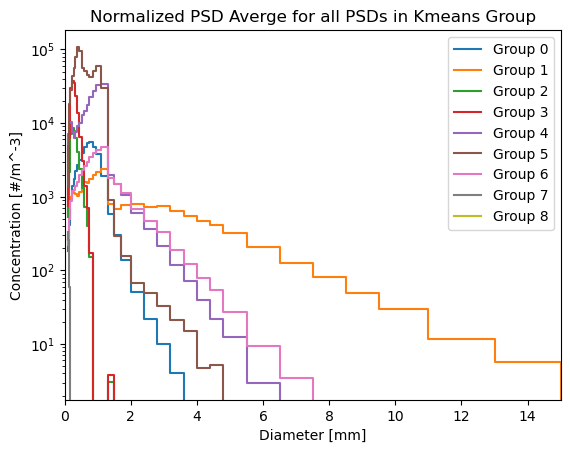

In [55]:
labels = ['Group 0', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8']
for n in range(nclusters):
    plt.step(PSD_ds.binmid.values*10**-3,avg_conc_ls_stable[n].values*(PSD_ds.binmid.values*10**-6), label=labels[n])
    plt.yscale('log')
    plt.xlim(0,15)
    plt.legend()
    plt.ylabel('Concentration [#/m^-3]')
    plt.xlabel('Diameter [mm]')
    plt.title('Normalized PSD Averge for all PSDs in Kmeans Group')